In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from itertools import product
from sklearn.cluster import AgglomerativeClustering

In [102]:
# Caricamento dati (MovieLens 100k)
url = "../datasets/ml-100k/u.data"
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(url, sep='\t', names=columns)
data.drop(columns='timestamp', inplace=True)
data.head()

train, test = train_test_split(data, test_size=0.2, random_state=42)
train = pd.DataFrame(train, columns=['user_id', 'movie_id', 'rating'])
test = pd.DataFrame(test, columns=['user_id', 'movie_id', 'rating'])
train.head()


,user_id,movie_id,rating
75220,807,1411,1
48955,474,659,5
44966,463,268,4
13568,139,286,4
92727,621,751,4


In [103]:
# Creazione della matrice utente-item
ui_train = train.pivot(index='user_id', columns='movie_id', values='rating')
# ui_matrix.fillna(0, inplace=True)
n_users, n_items = ui_train.shape
print(f'Numero di utenti {n_users}\nNumero di items: {n_items}')
ui_train.head()

Numero di utenti 943
Numero di items: 1653


movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,4.0,NaN,3.0,NaN,4.0,NaN,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
nnz = ui_train.count().sum() # Numero di ratings non nulli
sparsity = 1 - nnz / (n_users * n_items) # Sparsità della matrice
print(f"Numero utenti: {n_users}, Numero item: {n_items}")
print(f"Ratings non nulli: {nnz}")
print(f"Sparsità: {sparsity:.2%}")

Numero utenti: 943, Numero item: 1653
Ratings non nulli: 80000
Sparsità: 94.87%


In [105]:
# Riduzuione della matrice con SVD se la sparsità è alta con un numero di componenti ottimali
threshold_sparsity = 0.85
threshold_variance = 0.85
if sparsity > threshold_sparsity:
    print(f"Sparsità {sparsity:.2%} superiore alla soglia {threshold_sparsity:.2%}, si utilizza SVD per ridurre la matrice.")
    max_components = min(ui_train.shape) - 1
    svd_full = TruncatedSVD(n_components=max_components, random_state=42)
    svd_full.fit(ui_train.fillna(0))

    # Calcolo della varianza cumulativa
    cum_var = np.cumsum(svd_full.explained_variance_ratio_)

    # Trova il numero ottimale di componenti che spiegano almeno la soglia di varianza
    k_opt = np.searchsorted(cum_var, threshold_variance) + 1
    svd_opt = TruncatedSVD(n_components=k_opt, random_state=42)
    user_latent = svd_opt.fit_transform(ui_train.fillna(0))
    user_latent = pd.DataFrame(user_latent, index=ui_train.index) # SVD riduce la matrice
    print(f"Numero di componenti ottimali: {k_opt}")
    nnz_svd = np.count_nonzero(ui_train.values)
    sparsity_svd = 1 - nnz_svd / ui_train.size
    print(f"Sparsità della matrice ridotta dopo SVD: {sparsity_svd:.2%}")
else:
    print(f"Sparsità {sparsity:.2%} inferiore alla soglia {threshold_sparsity:.2%}, non si utilizza SVD.")

ui_train.head()

Sparsità 94.87% superiore alla soglia 85.00%, si utilizza SVD per ridurre la matrice.
Numero di componenti ottimali: 249
Sparsità della matrice ridotta dopo SVD: 0.00%


movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,4.0,NaN,3.0,NaN,4.0,NaN,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Calcolo della matrice di similarità tra utenti
user_similarity = cosine_similarity(ui_train.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=ui_train.index, columns=ui_train.index)

user_similarity_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.136196,0.030424,0.026203,0.284613,0.331412,0.319056,0.274139,0.083486,0.281396,...,0.277459,0.084849,0.205849,0.144161,0.133679,0.092367,0.216948,0.084181,0.104599,0.329288
2,0.136196,1.000000,0.114644,0.168220,0.093128,0.162165,0.095848,0.091360,0.149476,0.125701,...,0.149359,0.268977,0.320095,0.323347,0.241012,0.152655,0.230951,0.117484,0.166632,0.096719
3,0.030424,0.114644,1.000000,0.346894,0.000000,0.085071,0.032829,0.053875,0.060177,0.052552,...,0.021713,0.017707,0.154299,0.049358,0.107604,0.019022,0.101207,0.021959,0.127179,0.013805
4,0.026203,0.168220,0.346894,1.000000,0.011848,0.051287,0.075209,0.142100,0.060465,0.035202,...,0.034908,0.044480,0.087428,0.118082,0.100612,0.000000,0.151086,0.110324,0.112342,0.032367
5,0.284613,0.093128,0.000000,0.011848,1.000000,0.168527,0.298438,0.185290,0.039737,0.166013,...,0.276012,0.103529,0.085547,0.072429,0.104445,0.049198,0.204472,0.148028,0.099978,0.247527


Best k: 2 with silhouette score: 0.2619


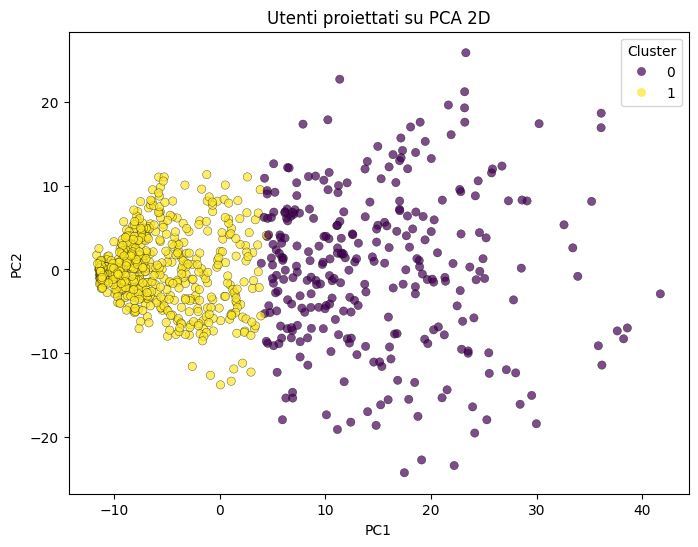

In [107]:
# Funzione per trovare il numero ottimale di cluster k usando silhouette score
def find_optimal_k(data, k_min=2, k_max=20):
    best_k, best_score = k_min, -1
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=42).fit(data)
        score = silhouette_score(data, km.labels_)
        if score > best_score:
            best_k, best_score = k, score
    print(f"Best k: {best_k} with silhouette score: {best_score:.4f}")
    return best_k

# Trova il numero ottimale di cluster
optimal_k = find_optimal_k(user_latent, k_min=2, k_max=20)

# Clustering degli utenti
labels_best = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(user_latent )
user_clusters = pd.Series(labels_best, index=ui_train.index)

# Visualizzazione scatter clusters sulle prime 2 componenti PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(user_latent)
# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_clusters, alpha=0.7, edgecolor='k', linewidth=0.3)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("Utenti proiettati su PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [108]:
# Dizionario per salvare le predizioni: ogni utente avrà un dizionario di film -> rating previsto
predictions_dict = defaultdict(dict)

# Flag per decidere se usare il clustering degli utenti
use_clustering = True

# Calcolo delle medie globali dei film (utilizzato come fallback in caso di cold start)
global_movie_means = ui_train.mean(skipna=True)

# Iterazione su tutti gli utenti nel training set per generare predizioni
for user_id in tqdm(ui_train.index, desc="Predizioni per tutti gli utenti"):

    # Determinazione degli utenti da considerare per il calcolo, in base al clustering
    if use_clustering:
        cluster_id = user_clusters.get(user_id)
        if cluster_id is None:
            # Utente non presente nei cluster (cold start): considera tutti gli utenti
            cluster_users = ui_train.index
        else:
            # Se l'utente è in un cluster, considera solo gli utenti di quel cluster
            cluster_users = user_clusters[user_clusters == cluster_id].index
    else:
        # Se non si usa il clustering, considera tutti gli utenti
        cluster_users = ui_train.index

    # Caso cold start utente: nessuna similarità disponibile
    if user_id not in user_similarity_df.index:
        # Predizione usando la media dei rating degli utenti nel cluster (o globali se cluster = tutti)
        mean_ratings = ui_train.loc[cluster_users].mean(skipna=True)
        for movie_id, rating in mean_ratings.items():
            if not np.isnan(rating):
                predictions_dict[user_id][movie_id] = rating
        continue

    # Recupera similarità tra l'utente attuale e gli altri nel cluster (escludendo se stesso)
    similarities = user_similarity_df.loc[user_id, cluster_users].drop(user_id, errors='ignore')
    rated_users = ui_train.loc[similarities.index]

    # Se non ci sono similarità o nessun utente ha valutato film, fallback alla media
    if similarities.empty or rated_users.empty:
        mean_ratings = ui_train.loc[cluster_users].mean(skipna=True)
        for movie_id, rating in mean_ratings.items():
            if not np.isnan(rating):
                predictions_dict[user_id][movie_id] = rating
        continue

    # Prepara i dati per la predizione basata su similarità (collaborative filtering)
    sim_values = similarities.values.reshape(-1, 1)  # Vettore colonna di similarità
    ratings_matrix = rated_users.fillna(0).values   # Matrice dei rating, riempiendo i NaN con 0
    mask_matrix = (~rated_users.isna()).astype(int).values  # Maschera binaria: 1 se il rating è presente, 0 altrimenti

    # Calcolo dei rating pesati usando la similarità
    weighted_ratings = np.dot(sim_values.T, ratings_matrix)
    sim_sums = np.dot(sim_values.T, mask_matrix)  # Somma delle similarità valide per ogni film

    # Evita divisioni per zero e calcola le predizioni finali
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_ratings = weighted_ratings / sim_sums
        predicted_ratings = predicted_ratings.flatten()  # Vettore 1D di predizioni

    # Assegna i rating previsti all'utente
    for i, movie_id in enumerate(ui_train.columns):
        if sim_sums[0, i] > 0:
            predictions_dict[user_id][movie_id] = predicted_ratings[i]
        else:
            # Cold start per film: usa la media globale del film come fallback
            fallback = global_movie_means[movie_id]
            if not np.isnan(fallback):
                predictions_dict[user_id][movie_id] = fallback

# Conversione del dizionario di predizioni in un DataFrame finale
pred_df = pd.DataFrame([
    (user_id, movie_id, rating)
    for user_id, movies in predictions_dict.items()
    for movie_id, rating in movies.items()
], columns=["user_id", "movie_id", "predicted_rating"])

# Mostra le prime righe del DataFrame risultante
pred_df.head()

Predizioni per tutti gli utenti: 100%|██████████| 943/943 [00:14<00:00, 65.43it/s]


,user_id,movie_id,predicted_rating
0,1,1,3.901806
1,1,2,3.183142
2,1,3,3.181574
3,1,4,3.592444
4,1,5,3.234911


In [109]:
# Valutazione dei rating predetti
# Unisci test con predizioni
valutazione_df = test.merge(pred_df, on=["user_id", "movie_id"], how="inner")

rmse = np.sqrt(mean_squared_error(valutazione_df["rating"], valutazione_df["predicted_rating"]))
mae = mean_absolute_error(valutazione_df["rating"], valutazione_df["predicted_rating"])

# Binarizzazione
threshold = 4.0
valutazione_df["true_label"] = (valutazione_df["rating"] >= threshold).astype(int)
valutazione_df["predicted_label"] = (valutazione_df["predicted_rating"] >= threshold).astype(int)

# Metriche di classificazione
accuracy = accuracy_score(valutazione_df["true_label"], valutazione_df["predicted_label"])
precision = precision_score(valutazione_df["true_label"], valutazione_df["predicted_label"])
recall = recall_score(valutazione_df["true_label"], valutazione_df["predicted_label"])

# Output
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

RMSE: 1.0242
MAE: 0.8134
Accuracy: 0.5603
Precision: 0.7800
Recall: 0.2795


In [110]:
# Liste per memorizzare precision e recall per ogni utente
precision_list = []
recall_list = []

# Soglia di rilevanza: un film con rating >= 4 è considerato "rilevante" o apprezzato
relevance_threshold = 4

# Numero di raccomandazioni da generare per utente (top-k)
k = 10

# Raggruppamento delle predizioni e dei dataset di test e train per utente
pred_grouped = pred_df.groupby("user_id")
test_grouped = test.groupby("user_id")
train_grouped = train.groupby("user_id")

# Valutazione per ogni utente che ha predizioni
for user_id, user_preds in pred_grouped:
    # Salta l'utente se non è presente sia nel test che nel train
    if user_id not in test_grouped.groups or user_id not in train_grouped.groups:
        continue

    # Recupera i film già visti dall'utente nel train (per non raccomandare film già noti)
    seen_movies = set(train_grouped.get_group(user_id)["movie_id"])

    # Rimuovi i film già visti dalle predizioni
    unseen_preds = user_preds[~user_preds["movie_id"].isin(seen_movies)]

    # Seleziona i primi k film non visti con il punteggio più alto
    topk_preds = (
        unseen_preds.sort_values("predicted_rating", ascending=False)
        .head(k)["movie_id"]
        .tolist()
    )

    # Se non ci sono film da raccomandare, passa all'utente successivo
    if len(topk_preds) == 0:
        print(f"Utente {user_id} non ha film da raccomandare.")
        continue

    # Estrai i film "rilevanti" (rating >= 4) per questo utente nel test set
    user_test = test_grouped.get_group(user_id)
    relevant_items = set(user_test[user_test["rating"] >= relevance_threshold]["movie_id"])

    # Se l'utente non ha film rilevanti nel test, ignora
    if not relevant_items:
        continue

    # Calcolo Precision@k e Recall@k
    hits = len(set(topk_preds) & relevant_items)  # Film raccomandati che sono anche rilevanti
    precision = hits / k                         # Precision: % dei raccomandati che sono rilevanti
    recall = hits / len(relevant_items)          # Recall: % dei rilevanti che sono stati raccomandati

    precision_list.append(precision)
    recall_list.append(recall)

# Calcolo delle medie globali
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)

# Output dei risultati
print(f"Precision@{k}: {avg_precision:.4f}")
print(f"Recall@{k}: {avg_recall:.4f}")
print(f"Utenti valutati: {len(precision_list)}")


Precision@10: 0.0004
Recall@10: 0.0007
Utenti valutati: 920


In [111]:
def agglomerative_grid_search(data: pd.DataFrame,  k_range=range(2, 21), linkage_options=['ward', 'average', 'complete'], metric_options=['euclidean', 'manhattan', 'cosine']) -> pd.DataFrame:
    """
    Esegue una ricerca a griglia sugli iperparametri di Agglomerative Clustering
    e restituisce un DataFrame ordinato per silhouette score decrescente.
    """
    results = []

    # Genera tutte le combinazioni valide
    for linkage, metric in tqdm(list(product(linkage_options, metric_options)), desc="Testing linkage/affinity"):
        # ward richiede euclidean
        if linkage == 'ward' and metric != 'euclidean':
            continue

        for k in k_range:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
                labels = model.fit_predict(data)

                if len(set(labels)) < 2:
                    continue  # silhouette score non valido

                score = silhouette_score(data, labels)
                results.append({
                    'n_clusters': k,
                    'linkage': linkage,
                    'metric': metric,
                    'silhouette_score': score
                })
            except Exception as e:
                continue  # ignora combinazioni non valide

    result_df = pd.DataFrame(results)
    return result_df.sort_values(by='silhouette_score', ascending=False).reset_index(drop=True)

In [112]:
# Esegui la grid search su user_latent
cv_results = agglomerative_grid_search(user_latent)

# Mostra i migliori risultati
print(cv_results.head())

# Miglior configurazione trovata
best_params = cv_results.iloc[0]
print(f"\nMigliori iperparametri trovati:")
print(f"n_clusters = {best_params['n_clusters']}")
print(f"linkage    = {best_params['linkage']}")
print(f"metric   = {best_params['metric']}")
print(f"silhouette = {best_params['silhouette_score']:.4f}")

Testing linkage/affinity: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

   n_clusters  linkage     metric  silhouette_score
0           2  average  euclidean          0.514733
1           3  average  euclidean          0.497179
2           2  average  manhattan          0.491618
3           4  average  euclidean          0.488829
4           4  average  manhattan          0.488829

Migliori iperparametri trovati:
n_clusters = 2
linkage    = average
metric   = euclidean
silhouette = 0.5147


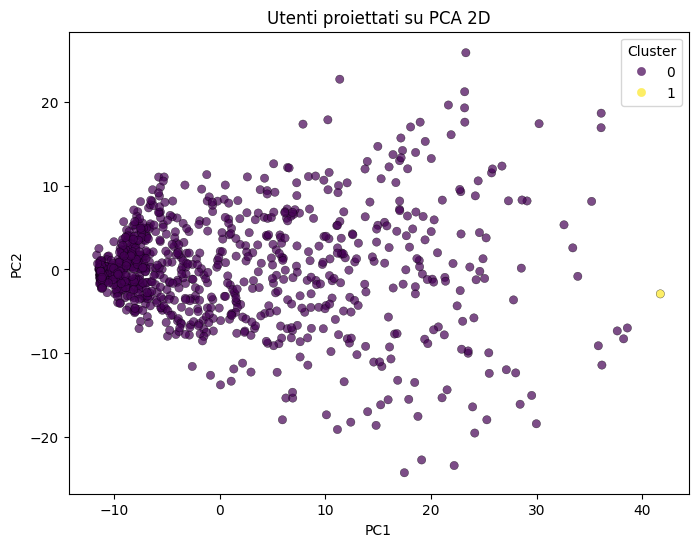

In [113]:
user_clusters_agglo = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    linkage=best_params['linkage'], 
    metric=best_params['metric']).fit_predict(user_latent)

clusters_agglo = pd.Series(user_clusters_agglo, index=ui_train.index, name='cluster')

# Visualizzazione scatter clusters sulle prime 2 componenti PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(user_latent)
# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agglo, alpha=0.7, edgecolor='k', linewidth=0.3)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("Utenti proiettati su PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()